### Importing Neccessary Packages

In [1]:
# import necessary packages
import sys
import os, time
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
#from torch.utils.tensorboard import SummaryWriter
#from torchvision.models.resnet import BasicBlock
#import torch.utils.model_zoo as model_zoo

import scipy.io
from sklearn.model_selection import train_test_split
from PIL import Image
sys.path.append('./models/')

# Check does your computer support using GPU
print("GPU_available={}".format(torch.cuda.is_available()))

GPU_available=True


### Load training and testing data

In [2]:
def saturateAmplitudes(data_set):
    data_set[data_set > 10000] = 10000
    data_set[data_set < -10000] = -10000
    return data_set

def balanceClasses(data_set, label_set):
    zero_indices = np.where(label_set == 0)[0]
    one_indices = np.where(label_set == 1)[0]

    max_count = min(len(zero_indices), len(one_indices))

    zero_keep_indices = np.random.choice(zero_indices, size=max_count, replace=False)
    one_keep_indices = np.random.choice(one_indices, size=max_count, replace=False)

    keep_indices = np.sort(np.concatenate((zero_keep_indices, one_keep_indices)))

    return data_set[keep_indices,:,:], label_set[keep_indices]

def includeChannel(data_set, channels):
    return data_set[:,channels,:]

In [3]:
mat = scipy.io.loadmat('EEG_samples_roi.mat')
EEG_samples = mat['EEG_samples']

def getDataSamples(EEG_samples, partic_id):

    data = EEG_samples['data'][0,partic_id]
    sick, sick_lables = data['sick'][0][0], []
    non_sick, non_sick_lables = data['non_sick'][0][0], []

    if np.any(sick):
        sick_lables = np.ones((sick.shape[0],1))

    if np.any(non_sick):
        non_sick_lables = np.zeros((non_sick.shape[0], 1))


    if (np.any(sick)) and (np.any(non_sick)):
        epoches = np.concatenate((sick, non_sick), axis=0)
        lables = np.concatenate((sick_lables, non_sick_lables), axis=0)
    elif (np.any(sick)) and (not np.any(non_sick)):
        epoches = sick
        lables = sick_lables
    elif (not np.any(sick)) and (np.any(non_sick)):
        epoches = non_sick
        lables = non_sick_lables

    epoches = saturateAmplitudes(epoches)
    epoches = includeChannel(epoches, [9, 10, 13, 14, 15, 16, 17, 18]) # Uncomment to inclead specifi channels

    return epoches, lables

test_id = 13 - 1 # for the zero index
no_participants = 29
train_data_set, train_label_set = [], []

for partic_id in range(0,no_participants):
    if test_id != partic_id:
        epoches, lables = getDataSamples(EEG_samples, partic_id)
        if not np.any(train_data_set):
            train_data_set = epoches
            train_label_set = lables
        else:
            train_data_set = np.concatenate((train_data_set, epoches), axis=0)
            train_data_set = np.nan_to_num(train_data_set, nan=0) # replace nan values with 0

            train_label_set = np.concatenate((train_label_set, lables), axis=0)
    else:
        test_data_set, test_label_set = getDataSamples(EEG_samples, partic_id)
        test_data_set = np.nan_to_num(test_data_set, nan=0) # replace nan values with 0

        valid_data_set, valid_label_set = getDataSamples(EEG_samples, partic_id)
        valid_data_set = np.nan_to_num(valid_data_set, nan=0) # replace nan values with 0

train_data_set, train_label_set = balanceClasses(train_data_set, train_label_set) # for ensuring a 50:50 ratio between sick and non-sick

data_set = np.concatenate((train_data_set, test_data_set), axis=0)
label_set = np.concatenate((train_label_set, test_label_set), axis=0)

print("-------- INFORMATION ON THE DATA ---------")
print("Shapes")
print("Train Data: "+str(train_data_set.shape)+" Train Lable: "+str(train_label_set.shape))
print("Test Data: "+str(test_data_set.shape)+" Test Lable: "+str(test_label_set.shape))
print("Valid Data: "+str(valid_data_set.shape)+" Train Lable: "+str(valid_label_set.shape))

print("***********************************************************************************")

print("Number of NANs in the data")
print("Train Data: "+str(np.sum(np.isnan(train_data_set)))+" Train Lable: "+str(np.sum(np.isnan(train_label_set))))
print("Test Data: "+str(np.sum(np.isnan(test_data_set)))+" Test Lable: "+str(np.sum(np.isnan(test_label_set))))
print("Valid Data: "+str(np.sum(np.isnan(valid_data_set)))+" Train Lable: "+str(np.sum(np.isnan(valid_label_set))))

print("***********************************************************************************")

print("Some stats on the data")
print("Number of 'non sick' samples: "+ str(np.count_nonzero(label_set == 0)))
print("Count voltage values > 10,000: "+ str(np.count_nonzero(data_set > 10000)))
print("Count voltage values < -10,000: "+ str(np.count_nonzero(data_set < -10000)))

print("**************************************** FULL DATASET *******************************************")

print("Number of 'sick' samples: "+ str(np.count_nonzero(label_set == 1)))
print("Number of 'non sick' samples: "+ str(np.count_nonzero(label_set == 0)))
print("Maximum Value in Data Set: " + str(np.amax(data_set)))
print("Minimum Value in Data Set: " + str(np.amin(data_set)))
print("Mean Value in Data Set: " + str(np.mean(data_set)))
print("Standard Daviation in Data Set: " + str(np.std(data_set)))

print("************************************* TRAINING DATASET **********************************************")

print("Number of 'sick' samples: "+ str(np.count_nonzero(train_label_set == 1)))
print("Number of 'non sick' samples: "+ str(np.count_nonzero(train_label_set == 0)))
print("Maximum Value in Training Set: " + str(np.amax(train_data_set)))
print("Minimum Value in Data Set: " + str(np.amin(train_data_set)))
print("Mean Value in Data Set: " + str(np.mean(train_data_set)))
print("Standard Daviation in Data Set: " + str(np.std(train_data_set)))

print("*************************************** TESTING DATASET ********************************************")

print("Number of 'sick' samples: "+ str(np.count_nonzero(test_label_set == 1)))
print("Number of 'non sick' samples: "+ str(np.count_nonzero(test_label_set == 0)))
print("Maximum Value in Testing Set: " + str(np.amax(test_data_set)))
print("Minimum Value in Data Set: " + str(np.amin(test_data_set)))
print("Mean Value in Data Set: " + str(np.mean(test_data_set)))
print("Standard Daviation in Data Set: " + str(np.std(test_data_set)))


-------- INFORMATION ON THE DATA ---------
Shapes
Train Data: (12120, 8, 250) Train Lable: (12120, 1)
Test Data: (457, 8, 250) Test Lable: (457, 1)
Valid Data: (457, 8, 250) Train Lable: (457, 1)
***********************************************************************************
Number of NANs in the data
Train Data: 0 Train Lable: 0
Test Data: 0 Test Lable: 0
Valid Data: 0 Train Lable: 0
***********************************************************************************
Some stats on the data
Number of 'non sick' samples: 6288
Count voltage values > 10,000: 0
Count voltage values < -10,000: 0
**************************************** FULL DATASET *******************************************
Number of 'sick' samples: 6289
Number of 'non sick' samples: 6288
Maximum Value in Data Set: 541.10803
Minimum Value in Data Set: -751.89
Mean Value in Data Set: -0.29930845
Standard Daviation in Data Set: 10.722514
************************************* TRAINING DATASET ******************************

### Creating Custom Dataset Class For EEG Samples

In [4]:
class EEGDataset(Dataset):

    def __init__(self, data_set, label_set, transform=None):
        
        self.transform = transform
        self.label_set = label_set
        self.data_set = data_set

    def __len__(self):
        return len(self.label_set)

    def __getitem__(self, idx):
        eeg_sample = self.data_set[idx,:,:]
        label = self.label_set[idx]

        if self.transform:
            eeg_sample = self.transform(eeg_sample)

        return eeg_sample, label

### Check Randomn Sample of EEG data

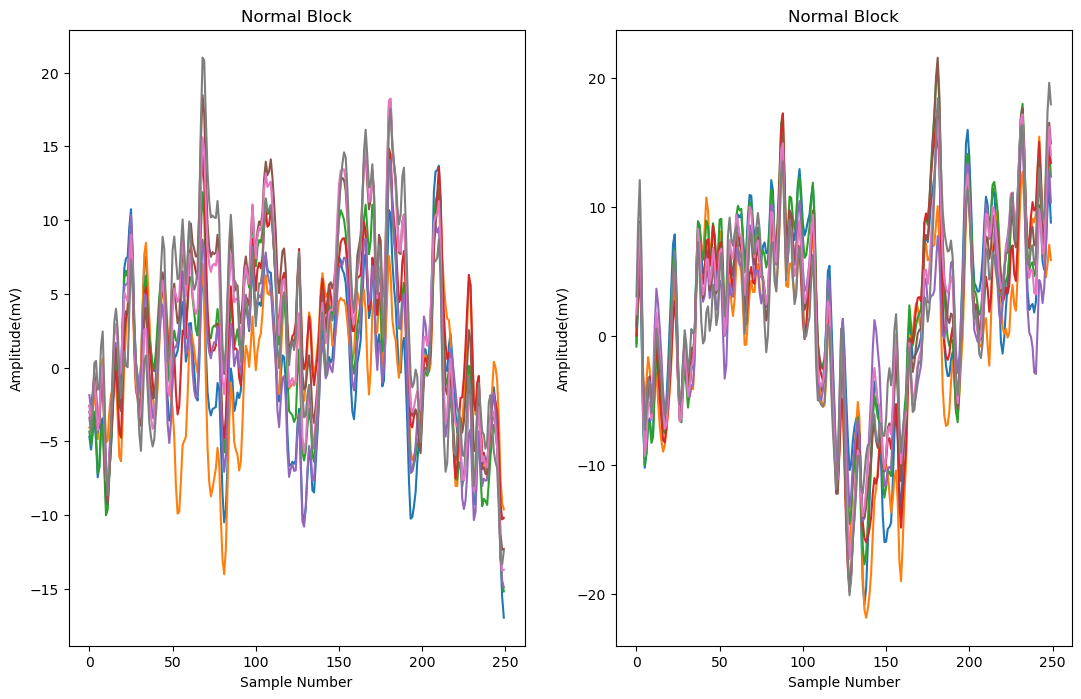

In [5]:
train_set = EEGDataset(data_set=valid_data_set, label_set=valid_label_set, transform=None)

f = plt.figure(figsize=(20,8))
idx = np.random.choice(range(train_set.__len__()), 2) #choose three eeg samples

plot_number = 1
for j in idx:
    eeg, eeg_label = train_set.__getitem__(idx=j)

    f.add_subplot(1,3, plot_number)
    for i in range(eeg.shape[0]):
        title = "Normal Block" if eeg_label == 0 else "Sick Block"
        plt.plot(range(250), eeg[i,:])
        plt.title(title)
        plt.ylabel("Amplitude(mV)")
        plt.xlabel("Sample Number")

    plot_number = plot_number + 1
plt.show()

In [6]:
N = 40 #number of batches
W = 0 #worker threads
data_transform = transforms.Compose([transforms.ToTensor()])

train_set = EEGDataset(data_set=train_data_set, label_set=train_label_set, transform=data_transform)
train_loader = DataLoader(train_set, batch_size=N, shuffle=True, num_workers=W)

valid_set = EEGDataset(data_set=valid_data_set, label_set=valid_label_set, transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=N, shuffle=True, num_workers=W)

test_set = EEGDataset(data_set=test_data_set, label_set=test_label_set, transform=data_transform)
test_loader = DataLoader(test_set, batch_size=N, shuffle=True, num_workers=W)

### Implementation of CNN in form of a Class

In [7]:
# THIS IS DONE IMPELMENTED IN THE 'models' FOLDER
from models.CNN_6 import Network

# instantiate a network
net = Network(num_classes=2)
model_no = 3 # For saving model files

### Implementation of Traning and Testing

In [8]:
# evaluation function
def eval(net, data_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9
    # your code here
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=np.exp(-7))
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    #net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        labels = torch.reshape(labels, (-1,))
        labels = labels.type(torch.LongTensor)
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images.float()) 
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images

    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9
    # your code here
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=np.exp(-7))

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        print("Cuda is Avaliable")
        
    epoches = 100
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            t_size = images.size()
            labels = torch.reshape(labels, (-1,))
            labels = labels.type(torch.LongTensor)

            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            test_image = images.float()
            test_weights = net.conv1.weight.data
            outputs = net(images.float())
            loss = loss_function(outputs, labels)
            loss.backward()

            optimizer.step()
            
            dummy,predicted = outputs.max(1)
            correct += predicted.eq(labels).sum()
            num_images += len(labels)

        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

### Running the traing and test implimentation to observe results

In [9]:
print('Please wait patiently, it may take some seconds...')
# TODO: train your network here
# your code here
net.float()
net.train(True)
net = train(net, train_loader, valid_loader)

Please wait patiently, it may take some seconds...
Cuda is Avaliable


c:\Users\Abdulsatar\Documents\UBICOMP\Thesis Work\Cyber Sickness\models\CNN_6.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax13(x)


epoch: 0, lr: 0.010000, accuracy: 0.497855, loss: 0.694197, valid accuracy: 0.501094
epoch: 1, lr: 0.010000, accuracy: 0.495545, loss: 0.691772, valid accuracy: 0.498906
epoch: 2, lr: 0.010000, accuracy: 0.500660, loss: 0.688391, valid accuracy: 0.498906
epoch: 3, lr: 0.010000, accuracy: 0.497277, loss: 0.696814, valid accuracy: 0.498906
epoch: 4, lr: 0.010000, accuracy: 0.492244, loss: 0.692484, valid accuracy: 0.501094
epoch: 5, lr: 0.010000, accuracy: 0.501650, loss: 0.693977, valid accuracy: 0.501094
epoch: 6, lr: 0.010000, accuracy: 0.497360, loss: 0.693632, valid accuracy: 0.501094
epoch: 7, lr: 0.010000, accuracy: 0.498020, loss: 0.692527, valid accuracy: 0.498906
epoch: 8, lr: 0.010000, accuracy: 0.500248, loss: 0.693491, valid accuracy: 0.501094
epoch: 9, lr: 0.010000, accuracy: 0.501320, loss: 0.695548, valid accuracy: 0.498906
epoch: 10, lr: 0.010000, accuracy: 0.495050, loss: 0.692043, valid accuracy: 0.498906
epoch: 11, lr: 0.010000, accuracy: 0.498185, loss: 0.695316, val

In [10]:
# TODO: test your network here on testing data (0.75 points)
# your code here
net.train(False)
acc_test = eval(net, test_loader)
print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

accuracy on testing data: 0.498906


In [11]:
from scipy import io

state_dict = net.state_dict()
io.savemat('data/Arch'+model_no+'/CNN.mat', {'state_dict' : state_dict})
torch.save(state_dict, 'data/Arch'+str(model_no)+'/CNN.pth')